<a href="https://colab.research.google.com/github/AdarshShah/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
> Adarsh Tushar Shah, 19473, MTech (A.I.)

2011 Pascal VOC dataset is used. Please ensure correct data path.

In [5]:
import numpy as np
from numpy.linalg import eig
from math import exp

from scipy.sparse.linalg import eigsh

from skimage import img_as_float
from skimage.io import imread,imsave
from skimage.color import rgb2gray
from skimage.transform import resize

from matplotlib import pyplot as plt

from tensorflow.keras.metrics import mean_squared_error

> Directory Path to Pascal VOC 2011 dataset

In [2]:
path = './aip'

# 1.0 Ncut

* The difficulties were faced in calculating the edge weights correctly. The edge weights here are distance based on the spatial and intensity gaussian distribution similar to the bilateral denoising filter equation except for the sum term. The standard deviation tuning was done using the trial and error method. 

* The second modification done is in the criteria of choosing each pixel's neighbours. The paper suggests to consider pixels within a certain circle i.e. (L2 norm dist(a,b) <= r). Instead L inf norm dist(a,b) <= r is taken with r = 20.

* The image is resized to 64x64. With this setting, it takes about 10 seconds to run.

In [3]:
def Ncut(image:np.ndarray,radius=20):

  image = rgb2gray(image)
  
  M,N = image.shape

  W = np.zeros(shape=(M*N,M*N))

  for i in range(M):
    for j in range(N):
      for k in range(-radius,radius+1):
        for l in range(-radius,radius+1):
          if i+k>=0 and i+k<M and j+l>=0 and j+l<N:
            a = N*i+j
            b = N*(i+k)+(j+l)
            W[a,b] = exp(-1*(((image[i,j]-image[i+k,j+l])**2)/0.005 + ((k)**2 + (l)**2)/(M*N)**2))


  D = np.diag([np.sum(W[i,:]) for i in range(M*N)])
  D_half = np.diag([1/np.sqrt(np.sum(W[i,:])) for i in range(M*N)])
  A = D_half@(D-W)@D_half
  eig_vals,eig_vectors = eigsh(A,k=2,which='SM')

  y = np.array([D_half[i,i]*eig_vectors[i,1] for i in range(M*N)],dtype=np.float32)
  y = np.signbit(y)

  res_image = np.zeros(image.shape)
  for i in range(M):
    for j in range(N):
      res_image[i,j] = y[N*i+j]
  
  return res_image


## 1.1 Evaluation Metrics



> Mean Intersection Over Union

In [12]:
def MIoU(image1:np.ndarray,image2:np.ndarray):
  image1 = np.where(image1>0,1,0)
  image2 = np.where(image2>0,1,0)
  intersection = np.sum(np.logical_and(image1,image2))
  union = np.sum(np.logical_or(image1,image2))
  return intersection/union

> Mean Squared Error

In [13]:
def MSE(image1:np.ndarray,image2:np.ndarray):
  image1 = np.where(image1>0,1,0)
  image2 = np.where(image2>0,1,0)
  return np.mean(np.square(image1-image2))

## 1.2 Example 1

> Please ensure correct data path before running

In [ ]:
image = resize(imread(f'{path}/TrainVal/VOCdevkit/VOC2011/JPEGImages/2007_000629.jpg'),(64,64))

#imsave('./outputs/Ncut/inputs/input1.jpg',image)

res_image = Ncut(image)

segmented_image = imread(f'{path}/TrainVal/VOCdevkit/VOC2011/SegmentationClass/2007_000629.png')
segmented_image = resize(segmented_image[:,:,0],(64,64))
segmented_image = np.where(segmented_image>0,1,0)

#imsave('./outputs/Ncut/outputs/output1.jpg',segmented_image)

plt.subplot(131)
plt.imshow(image,'brg')
plt.subplot(132)
plt.imshow(res_image,'gray')
plt.subplot(133)
plt.imshow(segmented_image,'gray')
plt.show()
plt.clf()

In [53]:
MIoU(res_image,segmented_image)

0.28998242530755713

In [54]:
MSE(res_image,segmented_image)

0.591796875

## 1.3 Example 2

> Please ensure correct data path before running

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/tmp/ipykernel_20612/2548826558.py:11: UserWarning: ./outputs/Ncut/outputs/output2.jpg is a low contrast image
  imsave('./outputs/Ncut/outputs/output2.jpg',segmented_image)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


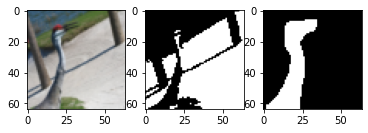

<Figure size 432x288 with 0 Axes>

In [8]:
image = resize(imread(f'{path}/TrainVal/VOCdevkit/VOC2011/JPEGImages/2007_000068.jpg'),(64,64))

#imsave('./outputs/Ncut/inputs/input2.jpg',image)

res_image = Ncut(image)

segmented_image = imread(f'{path}/TrainVal/VOCdevkit/VOC2011/SegmentationClass/2007_000068.png')
segmented_image = resize(segmented_image[:,:,0],(64,64))
segmented_image = np.where(segmented_image>0,1,0)

#imsave('./outputs/Ncut/outputs/output2.jpg',segmented_image)

plt.subplot(131)
plt.imshow(image,'brg')
plt.subplot(132)
plt.imshow(res_image,'gray')
plt.subplot(133)
plt.imshow(segmented_image,'gray')
plt.show()
plt.clf()

In [56]:
MIoU(res_image,segmented_image)

0.2700693756194252

In [57]:
MSE(res_image,segmented_image)

0.359619140625

# 2.0 FCN Model

* This model is designed with the aim of segmenting objects from background. Hence the output is a Binary Map seperating background from images.
* The fully connected layers are removed from VGG16
* The skip architecture is introduced to learn semantic features from deep layers and spatial features from shallow layers.
* The Conv2DTranspose operator is an upsampling operator which learns itself to be some kind of bilinear interpolator based on training given.
* The concatenate operator in the model performs the concatenation of deep and shallow layers.
* The images are resized to 224x224

In [9]:
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, MaxPooling2D, BatchNormalization, Conv2D, Flatten, AveragePooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,mean_squared_error
from tensorflow.keras.activations import softmax, relu

from skimage.filters import threshold_otsu

import pandas as pd

In [10]:
vgg = VGG16()

2022-02-15 13:25:23.098293: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-15 13:25:31.381322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28739 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-02-15 13:25:31.383124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30951 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-02-15 13:25:31.384663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

In [11]:
vgg.trainable=False

In [12]:
input = Input(shape=(224,224,3))

y = input

for i in range(1,4):
  y = vgg.layers[i](y)

output1 = Conv2DTranspose(1,(2,2),(2,2),activation='relu')(y)

for i in range(4,7):
  y = vgg.layers[i](y)

output2 = Conv2DTranspose(1,(4,4),(4,4),activation='relu')(y)

for i in range(7,11):
  y = vgg.layers[i](y)

output3 = Conv2DTranspose(1,(8,8),(8,8),activation='relu')(y)

for i in range(11,15):
  y = vgg.layers[i](y)

output4 = Conv2DTranspose(1,(16,16),(16,16),activation='relu')(y)

for i in range(15,19):
  y = vgg.layers[i](y)

output5 = Conv2DTranspose(1,(32,32),(32,32),activation='relu')(y)

y = Concatenate(-1)([input,output1,output2,output3,output4,output5])

output = Conv2D(1,(1,1),(1,1),padding='same',activation='sigmoid')(y)

In [13]:
fcn = Model(input,output)

In [14]:
fcn.compile(optimizer=Adam(),loss=mean_squared_error)

In [15]:
fcn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[1][0]']           
                                )                                                             

## 2.1 Data Preparation

* The Train/Validation/Test Data is obtained from Pascal VOC 2011 dataset.

In [16]:
train_files = pd.read_csv("./aip/TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/train.txt")
trainval_files = pd.read_csv("./aip/TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/trainval.txt")
val_files = pd.read_csv("./aip/TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/val.txt")

In [17]:
filename = train_files['2007_000032'].iloc[np.random.randint(train_files['2007_000032'].count())]

Input Image : RGB 224 x 224 x 3

/tmp/ipykernel_20612/2570459712.py:2: UserWarning: ./outputs/FCN/Inputs/input.jpg is a low contrast image
  imsave('./outputs/FCN/Inputs/input.jpg',segmented_image)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


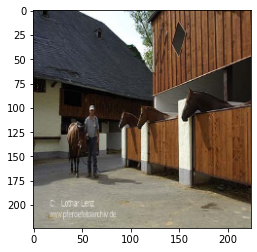

<Figure size 432x288 with 0 Axes>

In [18]:
image = resize(imread(f'{path}/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg'),(224,224))
imsave('./outputs/FCN/Inputs/input.jpg',segmented_image)

plt.imshow(image,'brg')
plt.show()
plt.clf()

Output Image : 224x224

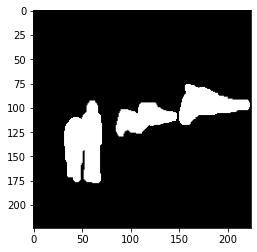

<Figure size 432x288 with 0 Axes>

In [19]:
image = imread(f'{path}/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
image = resize(image[:,:,0],(224,224))
image = np.where(image>0,1,0)
plt.imshow(image,'gray')
plt.show()
plt.clf()

Train Data Preparation

In [20]:
xtrain = list()
for filename in train_files['2007_000032']:
  image = resize(img_as_float(imread(f'{path}/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg')),(224,224))
  xtrain.append(image)

xtrain = tf.convert_to_tensor(xtrain)

In [21]:
ytrain = list()
for filename in train_files['2007_000032']:
  image = imread(f'{path}/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
  image = resize(image[:,:,0],(224,224))
  image = np.where(image>0,1,0)
  ytrain.append(image)

ytrain = tf.convert_to_tensor(ytrain)

Validation Data Preparation

In [22]:
xVal = list()
for filename in trainval_files['2007_000032']:
  image = resize(img_as_float(imread(f'{path}/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg')),(224,224))
  xVal.append(image)

xVal = tf.convert_to_tensor(xVal)

In [23]:
yVal = list()
for filename in trainval_files['2007_000032']:
  image = imread(f'{path}/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
  image = resize(image[:,:,0],(224,224))
  image = np.where(image>0,1,0)
  yVal.append(image)

yVal = tf.convert_to_tensor(yVal)

Test Data Preparation

In [24]:
xtest = list()
for filename in val_files['2007_000033']:
  image = resize(img_as_float(imread(f'{path}/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg')),(224,224))
  xtest.append(image)

xtest = tf.convert_to_tensor(xtest)

In [25]:
ytest = list()
for filename in val_files['2007_000033']:
  image = imread(f'{path}/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
  image = resize(image[:,:,0],(224,224))
  image = np.where(image>0,1,0)
  ytest.append(image)

ytest = tf.convert_to_tensor(ytest)

## 2.2 Model Training

In [26]:
fcn.fit(x=xtrain,y=ytrain,epochs=50,validation_data=(xVal,yVal))

Epoch 1/50


2022-02-15 13:32:33.043013: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


35/35 [==============================] - 13s 282ms/step - loss: 0.1714 - val_loss: 0.1471
Epoch 2/50
35/35 [==============================] - 6s 179ms/step - loss: 0.1401 - val_loss: 0.1370
Epoch 3/50
35/35 [==============================] - 7s 212ms/step - loss: 0.1337 - val_loss: 0.1326
Epoch 4/50
35/35 [==============================] - 6s 180ms/step - loss: 0.1286 - val_loss: 0.1290
Epoch 5/50
35/35 [==============================] - 7s 199ms/step - loss: 0.1258 - val_loss: 0.1281
Epoch 6/50
35/35 [==============================] - 6s 183ms/step - loss: 0.1237 - val_loss: 0.1249
Epoch 7/50
35/35 [==============================] - 6s 189ms/step - loss: 0.1215 - val_loss: 0.1235
Epoch 8/50
35/35 [==============================] - 6s 187ms/step - loss: 0.1201 - val_loss: 0.1224
Epoch 9/50
35/35 [==============================] - 6s 181ms/step - loss: 0.1192 - val_loss: 0.1215
Epoch 10/50
35/35 [==============================] - 6s 181ms/step - loss: 0.1184 - val_loss: 0.1212
Epoch 11/

## 2.3 Model Evaluation

> Randomly generate test cases from test set.

In [68]:
filename = val_files['2007_000033'].iloc[np.random.randint(val_files['2007_000033'].count())]

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


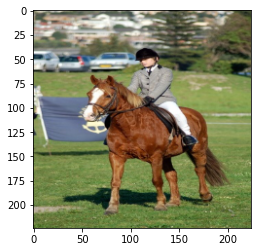

<Figure size 432x288 with 0 Axes>

In [86]:
image = resize(imread(f'{path}/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg'),(224,224))

imsave('./outputs/FCN/Inputs/output1.jpg',image)


plt.imshow(image,'brg')
plt.show()
plt.clf()

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


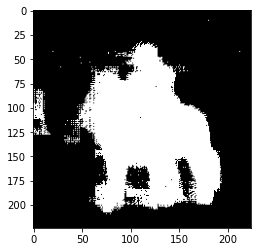

In [82]:
out = fcn.predict(x=np.reshape(image,(-1,224,224,3)))
out = np.reshape(out,(224,224))
out = np.round(out)
imsave('./outputs/FCN/outputs/output1.jpg',out)

plt.imshow(out,'gray')
plt.show()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


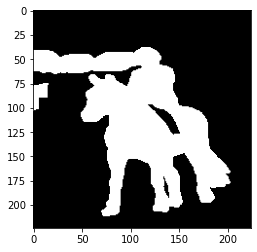

In [87]:
segmented_image = imread(f'{path}/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
segmented_image = resize(segmented_image[:,:,0],(224,224))
segmented_image = np.round(segmented_image)
#imsave('./outputs/FCN/outputs/ground_truth.jpg',segmented_image)
plt.imshow(segmented_image,'gray')
plt.show()

> Mean Squared Error

In [83]:
MSE(out,segmented_image)

0.12065529336734694

> Mean Intersection Over Union

In [84]:
MIoU(out,segmented_image)

0.6702434773135791

# 3.0 Pretrained Fully Convolution Layer from Pytorch

* The pre-trained model is based on resnet-50.

Reference : [Pytorch FCN](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_fcn_resnet101.ipynb#scrollTo=hungarian-valve)

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
model.eval()

## Model Prediction

In [9]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(f'{path}/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg')
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

In [ ]:
output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)
imsave("output.jpg",np.array(output_predictions))

## 3.2 Model Evaluation

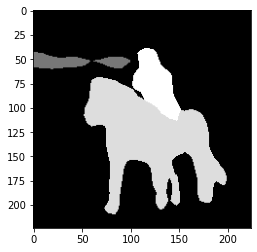

In [7]:
plt.imshow(output_predictions,'gray')
plt.show()

In [14]:
segmented_image = imread(f'{path}/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
segmented_image = resize(segmented_image[:,:,0],(224,224))
segmented_image = np.round(segmented_image)
#imsave('./outputs/FCN/outputs/ground_truth.jpg',segmented_image)
plt.imshow(segmented_image,'gray')
plt.show()

> Mean Squared Error

In [15]:
MSE(output_predictions,segmented_image)

0.10028698979591837

> Mean Intersection Over Union

In [16]:
MIoU(output_predictions,segmented_image)

0.7136842105263158